In [1]:
pip install pandas numpy scikit-learn tensorflow keras transformers matplotlib seaborn keras-tuner requests

  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.4.1+cu121 requires typing-extensions>=4.8.0, but you have typing-extensions 4.5.0 which is incompatible.


Step 2: Dataset Preparation

Step 3: Preprocessing

Step 4: Model Design
Model 1: LSTM with Pre-trained Embeddings

In [3]:
import pandas as pd
import numpy as np
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    Trainer, TrainingArguments
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def load_data():
    train_df = pd.read_csv("train.csv")
    test_df = pd.read_csv("test.csv")
    test_labels = pd.read_csv("test_labels.csv")

    # Merge and filter test data
    test_full = pd.merge(test_df, test_labels, on="id")
    mask = (test_full[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] != -1).any(axis=1)
    scored_test = test_full[mask]

    return train_df, scored_test

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+|[^a-zA-Z\s]", "", str(text))
    return text.lower().strip()

# Process datasets
train_df, test_df = load_data()
train_df["cleaned_text"] = train_df["comment_text"].apply(clean_text)
test_df["cleaned_text"] = test_df["comment_text"].apply(clean_text)

# Split training data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["cleaned_text"],
    train_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]],
    test_size=0.2,
    random_state=42
)


In [5]:
class ToxicityDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True).values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encoding = self.tokenizer(
            text, max_length=self.max_len,
            padding="max_length", truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Initialize tokenizer and datasets
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = ToxicityDataset(train_texts, train_labels, tokenizer)
val_dataset = ToxicityDataset(val_texts, val_labels, tokenizer)
test_dataset = ToxicityDataset(test_df["cleaned_text"], test_df.iloc[:, 2:8], tokenizer)

In [6]:
class BiLSTM(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=64):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(hidden_dim * 2, 6)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        return self.fc(x)

class GRUModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim=200, hidden_dim=128):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.gru = torch.nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(hidden_dim, 6)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x, _ = self.gru(x)
        x = self.dropout(x[:, -1, :])
        return self.fc(x)

# BERT Model
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=6,
    problem_type="multi_label_classification"
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10, patience=3):
    best_val_loss = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids, attention_mask)
                val_loss += criterion(outputs, labels).item()
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return model, train_losses, val_losses


In [7]:
pip install transformers[torch]

  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.


In [ ]:
# Common parameters
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
criterion = torch.nn.BCEWithLogitsLoss()

# Train BiLSTM
bilstm = BiLSTM(tokenizer.vocab_size).to(device)
bilstm_optimizer = torch.optim.AdamW(bilstm.parameters(), lr=1e-3, weight_decay=1e-4)
bilstm, bilstm_train_loss, bilstm_val_loss = train_model(
    bilstm, train_loader, val_loader, bilstm_optimizer, criterion
)

In [7]:
# Train GRU
gru = GRUModel(tokenizer.vocab_size).to(device)
gru_optimizer = torch.optim.AdamW(gru.parameters(), lr=1e-3)
gru, gru_train_loss, gru_val_loss = train_model(
    gru, train_loader, val_loader, gru_optimizer, criterion
)

Early stopping at epoch 6


In [8]:
# Train BERT
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=64,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
)
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)
trainer.train()

/home/javokhir/miniconda3/envs/parkour/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: founderoffounders. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.042600,0.040201
2,0.034100,0.037550
3,0.026600,0.039049


TrainOutput(global_step=5985, training_loss=0.038386058409012845, metrics={'train_runtime': 1577.9864, 'train_samples_per_second': 242.694, 'train_steps_per_second': 3.793, 'total_flos': 2.5191683373625344e+16, 'train_loss': 0.038386058409012845, 'epoch': 3.0})

In [16]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].cpu().numpy()

            # Forward pass to get outputs
            outputs = model(input_ids, attention_mask=attention_mask)
            
            if hasattr(outputs, 'logits'):
                # For transformer models like BERT, GPT, etc.
                logits = outputs.logits  # Extract logits from the SequenceClassifierOutput
            else:
                # For models like BiLSTM, GRU that return raw logits directly
                logits = outputs

            # Apply sigmoid to logits for binary classification
            logits = torch.sigmoid(logits).cpu().numpy()

            preds = (logits > 0.5).astype(int)
            all_preds.extend(preds)
            all_labels.extend(labels)

    # Convert lists to NumPy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    results = {}
    for i, col in enumerate(["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]):
        results[col] = {
            "precision": precision_score(all_labels[:, i], all_preds[:, i], average="macro"),
            "recall": recall_score(all_labels[:, i], all_preds[:, i], average="macro"),
            "f1": f1_score(all_labels[:, i], all_preds[:, i], average="macro")
        }

    results["macro_avg"] = {
        "precision": np.mean([v["precision"] for v in results.values()]),
        "recall": np.mean([v["recall"] for v in results.values()]),
        "f1": np.mean([v["f1"] for v in results.values()])
    }

    return results

# Evaluate all models
test_loader = DataLoader(test_dataset, batch_size=16)
print("BiLSTM Results:", evaluate_model(bilstm, test_loader, device))
print("GRU Results:", evaluate_model(gru, test_loader, device))
print("BERT Results:", evaluate_model(bert_model, test_loader, device))

/home/javokhir/miniconda3/envs/parkour/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


BiLSTM Results: {'toxic': {'precision': 0.7492213287171239, 'recall': 0.8868232217402314, 'f1': 0.7957798362557318}, 'severe_toxic': {'precision': 0.734252201973746, 'recall': 0.5487319104963466, 'f1': 0.5798093547191816}, 'obscene': {'precision': 0.8054120702697762, 'recall': 0.8637310148673519, 'f1': 0.8315362800222864}, 'threat': {'precision': 0.4983509956547563, 'recall': 0.5, 'f1': 0.4991741359740108}, 'insult': {'precision': 0.7875795038136046, 'recall': 0.8001319316048294, 'f1': 0.7936980114106615}, 'identity_hate': {'precision': 0.49443515232988916, 'recall': 0.4999604843043657, 'f1': 0.4971824676396388}, 'macro_avg': {'precision': 0.6782085421264826, 'recall': 0.6832297605021876, 'f1': 0.6661966810035852}}
GRU Results: {'toxic': {'precision': 0.7708821472672851, 'recall': 0.8697058801504247, 'f1': 0.8093519281232718}, 'severe_toxic': {'precision': 0.6953761106119597, 'recall': 0.7011972720602494, 'f1': 0.6982430764635135}, 'obscene': {'precision': 0.8147930140693009, 'recall':

In [17]:
def generate_iiif_annotations(df, num_samples=10):
    annotations = []
    for _, row in df.sample(num_samples).iterrows():
        annotation = {
            "@context": "http://iiif.io/api/presentation/3/context.json",
            "id": f"https://example.org/annotation/{row['id']}",
            "type": "Annotation",
            "motivation": "classifying",
            "body": {
                "type": "TextualBody",
                "value": str(row[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].to_dict()),
                "format": "text/plain"
            },
            "target": {
                "source": f"https://example.org/wiki_comments/{row['id']}.jpg",
                "selector": {"type": "FragmentSelector", "value": "xywh=0,0,500,500"}
            }
        }
        annotations.append(annotation)
    return annotations

with open("iiif_annotations.json", "w") as f:
    json.dump(generate_iiif_annotations(test_df), f)

In [19]:
def analyze_errors(model, test_loader, device):
    model.eval()
    errors = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].cpu().numpy()
            
            # Forward pass to get outputs
            outputs = model(input_ids, attention_mask=attention_mask)
            
            # Extract logits from the SequenceClassifierOutput
            if hasattr(outputs, 'logits'):
                logits = outputs.logits
            else:
                logits = outputs
            
            # Apply sigmoid to logits for binary classification
            outputs = torch.sigmoid(logits).cpu().numpy()
            preds = (outputs > 0.5).astype(int)

            for i in range(len(preds)):
                if not np.array_equal(preds[i], labels[i]):
                    errors.append({
                        "text": test_df["cleaned_text"].iloc[i],
                        "true": labels[i],
                        "pred": preds[i]
                    })
    return errors[:10]  # Return first 10 errors

print("BERT Error Examples:", analyze_errors(bert_model, test_loader, device))

BERT Error Examples: [{'text': 'arabs are committing genocide in iraq but no protests in europe  \n\n may europe also burn in hell', 'true': array([1., 0., 0., 0., 0., 0.], dtype=float32), 'pred': array([1, 0, 0, 0, 0, 1])}, {'text': 'cut it short if you have sources stating the rok is sovereign post them otherwise please aknowledge wp is not the place to make or', 'true': array([0., 0., 0., 0., 0., 0.], dtype=float32), 'pred': array([1, 0, 0, 1, 0, 0])}, {'text': 'if ollie or others think that one list of the oldest people we know about is too long the easy answer is to raise the cutoff age  is purely a round number and a full  years shorter then the record we can make it the top  or top  or everyone above   tell us what the maximum list size is and we can set a threshold', 'true': array([1., 0., 1., 0., 1., 0.], dtype=float32), 'pred': array([1, 1, 1, 0, 1, 1])}, {'text': 'arabs are committing genocide in iraq but no protests in europe  \n\n may europe also burn in hell', 'true': arr

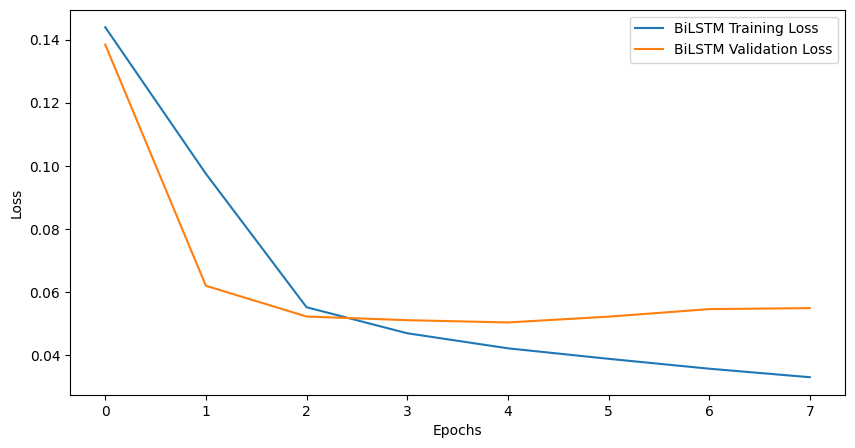

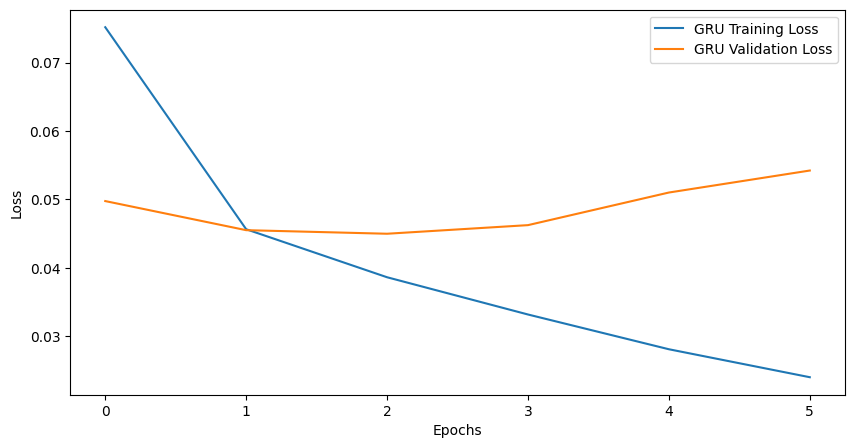

In [20]:
# [10] Visualization
def plot_metrics(model_name, train_loss, val_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label=f"{model_name} Training Loss")
    plt.plot(val_loss, label=f"{model_name} Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_metrics("BiLSTM", bilstm_train_loss, bilstm_val_loss)
plot_metrics("GRU", gru_train_loss, gru_val_loss)